In [1]:
import torch 
import torch.nn as nn
from model import model_loader
import deepspeed
from deepspeed.profiling.flops_profiler import get_model_profile
from rich.console import Console
from rich.table import Table

console = Console()

/workspace/long-attention/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/venv/main/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/venv/main/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
def format_params(num):
    if num >= 1_000_000_000:
        return f"{num / 1_000_000_000:.2f} B"
    elif num >= 1_000_000:
        return f"{num / 1_000_000:.2f} M"
    else:
        return f"{num / 1_000:.2f} K"

In [3]:
def get_peak_memory_mb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024 / 1024
    return 0.0

def count_parameters(model):
    """Returns formatted string of parameter count."""
    return sum(p.numel() for p in model.parameters())

In [4]:
def measure_throughput(model, device, batch_size, seq_len, num_iter=50):
    """
    Measures tokens per second using dummy inputs.
    """
    # Create dummy input (random integers)
    dummy_input = torch.randint(0, 50257, (batch_size, seq_len)).to(device)

    # Warmup (compile graphs, allocate memory)
    console.print("[dim]Warming up GPU...[/dim]")
    with torch.no_grad():
        for _ in range(5):
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Measurement Loop
    console.print(f"[dim]Running {num_iter} iterations...[/dim]")
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iter):
            _ = model(dummy_input)
            
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        
    end_time = time.time()
    
    total_time = end_time - start_time
    total_tokens = batch_size * seq_len * num_iter
    tokens_per_sec = total_tokens / total_time
    
    return tokens_per_sec, total_time

In [5]:
def profiling_model(model_type, model_size, batch_size=1, seq_len=2048):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    console.print(f"[bold cyan]Profiling {model_type.upper()} ({model_size}) on {device.upper()}[/bold cyan]")
    
    # 1. Load Model
    # Note: Using your factory function. 
    model, tokenizer = model_loader.get_model_and_tokenizer(
        model_type=model_type, 
        model_size=model_size, 
        seq_len = seq_len,
        device=device
    )
    model.eval()
    model.to(device)

    # 2. Create Dummy Input
    # We need this for both FLOPs counting and Throughput testing
    input_ids = torch.randint(100, 10000, (batch_size, seq_len)).to(device)

    # ---------------------------------------------------------
    # 3. MEASURE FLOPs (using DeepSpeed Profiler)
    # ---------------------------------------------------------
    console.print("\n[1/3] Measuring FLOPs with DeepSpeed Profiler...")
    
    # This runs a forward pass and hooks into every layer to count operations
    flops, macs, params = get_model_profile(
        model=model,
        args=(input_ids,), 
        print_profile=False, # Set to True if you want a huge list of every layer
        detailed=False,      
        warm_up=1,
        as_string=False      # Return raw numbers for calculation
    )

    # ---------------------------------------------------------
    # 4. MEASURE THROUGHPUT (Tokens per Second)
    # ---------------------------------------------------------
    console.print("\n[2/3] Measuring Throughput (Speed)...")
    
    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(input_ids)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Benchmark Loop
    iterations = 50
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(input_ids)
    end_event.record()
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Calculations
    elapsed_time_ms = start_event.elapsed_time(end_event)
    avg_time_per_iter = (elapsed_time_ms / 1000) / iterations
    
    total_tokens = batch_size * seq_len
    tokens_per_sec = total_tokens / avg_time_per_iter

    # ---------------------------------------------------------
    # 5. CALCULATE ACHIEVED PERFORMANCE
    # ---------------------------------------------------------
    # FLOPs per second = (FLOPs per forward pass) / (Time per forward pass)
    flops_per_sec = flops / avg_time_per_iter
    tflops = flops_per_sec / 1e12
    
    peak_mem = get_peak_memory_mb()

    # ---------------------------------------------------------
    # 6. DISPLAY RESULTS TABLE
    # ---------------------------------------------------------
    console.print("\n[3/3] Generating Report...")
    
    table = Table(title=f"Profiling Results: {model_type.upper()} ({model_size})")
    table.add_column("Metric", style="cyan")
    table.add_column("Value", style="green")

    table.add_row("Parameters", format_params(params))
    table.add_row("Context Length", str(seq_len))
    table.add_row("Batch Size", str(batch_size))
    table.add_row("Latency", f"{avg_time_per_iter*1000:.2f} ms")
    table.add_row("Throughput", f"{tokens_per_sec:.2f} tokens/sec")
    table.add_row("Total FLOPs (1 pass)", f"{flops / 1e9:.2f} GFLOPs")
    table.add_row("Achieved Compute", f"{tflops:.4f} TFLOPS")
    table.add_row("Peak Memory", f"{peak_mem:.2f} MB")

    console.print(table)
    return params

In [6]:
profiling_model("holo", "small", batch_size=1, seq_len=4096)

Profiling HOLO (small) on CUDA

[Model Loader] Initializing Holo (small)...


[1/3] Measuring FLOPs with DeepSpeed Profiler...

[2/3] Measuring Throughput (Speed)...

[3/3] Generating Report...

       Profiling Results: HOLO (small)        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Value               ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Parameters           │ 180.26 M            │
│ Context Length       │ 4096                │
│ Batch Size           │ 1                   │
│ Latency              │ 151.00 ms           │
│ Throughput           │ 27126.30 tokens/sec │
│ Total FLOPs (1 pass) │ 1476.38 GFLOPs      │
│ Achieved Compute     │ 9.7775 TFLOPS       │
│ Peak Memory          │ 21326.26 MB         │
└──────────────────────┴─────────────────────┘

180258336

In [7]:
profiling_model("gpt2", "small", batch_size=1, seq_len=2048)

In [8]:
# profiling_model("mamba", "small", batch_size=1, seq_len=2048)

/venv/main/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/venv/main/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/workspace/long-attention/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Profiling gpt2 at seq_len=128 ---
--- Profiling gpt2 at seq_len=256 ---
--- Profiling gpt2 at seq_len=512 ---
--- Profiling gpt2 at seq_len=1024 ---
--- Profiling gpt2 at seq_len=2048 ---
--- Profiling gpt2 at seq_len=4096 ---
--- Profiling mamba at seq_len=128 ---
--- Profiling mamba at seq_len=256 ---
--- Profiling mamba at seq_len=512 ---
--- Profiling mamba at seq_len=1024 ---
--- Profiling mamba at seq_len=2048 ---
--- Profiling mamba at seq_len=4096 ---
--- Profiling holo at seq_len=128 ---
--- Profiling holo at seq_len=256 ---
--- Profiling holo at seq_len=512 ---
--- Profiling holo at seq_len=1024 ---
--- Profiling holo at seq_len=2048 ---
--- Profiling holo at seq_len=4096 ---

Plot saved to 'scaling_benchmark.png'


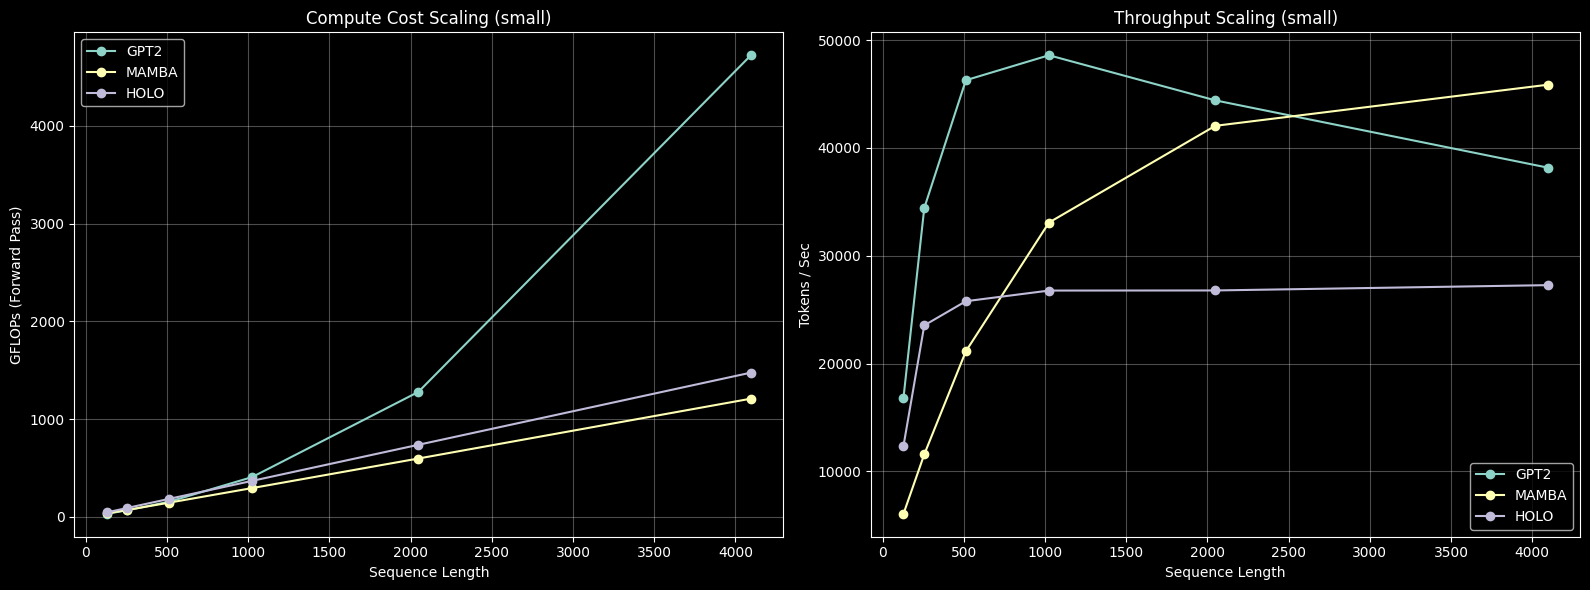

In [1]:
import torch
import matplotlib.pyplot as plt
import deepspeed
from deepspeed.profiling.flops_profiler import get_model_profile
from model import model_loader 
import time
import gc

# --- Configuration ---
# Now we force GPT-2 to try these lengths too
SEQ_LENS = [128, 256, 512, 1024, 2048, 4096]
MODELS = ["gpt2", "mamba", "holo"]
MODEL_SIZE = "small"
BATCH_SIZE = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def cleanup():
    """Aggressively clears memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        try:
            torch.cuda.synchronize()
        except Exception:
            pass # Ignore sync errors if context is already borked

def get_metrics(model_type, seq_len):
    """
    Loads model and returns (GFLOPs, Throughput).
    Handles OOM and IndexErrors gracefully.
    """
    print(f"--- Profiling {model_type} at seq_len={seq_len} ---")
    
    # Initialize variables to ensure cleanup works even if they aren't assigned
    model = None
    input_ids = None
    gflops = None
    tokens_per_sec = None

    try:
        # 1. Load Model
        # We pass the seq_len to the factory. 
        # Note: Standard GPT-2 might ignore this and stick to 1024, leading to a crash later.
        model, _ = model_loader.get_model_and_tokenizer(
            model_type=model_type, 
            model_size=MODEL_SIZE, 
            seq_len=seq_len, 
            device=DEVICE
        )
        model.eval()

        # 2. Dummy Input
        input_ids = torch.randint(100, 10000, (BATCH_SIZE, seq_len)).to(DEVICE)

        # 3. Measure FLOPs (One Pass)
        # DeepSpeed might crash here if dimensions mismatch
        flops, _, _ = get_model_profile(
            model=model,
            args=(input_ids,), 
            print_profile=False, detailed=False, warm_up=1, as_string=False
        )
        gflops = flops / 1e9

        # 4. Measure Throughput
        # Warmup
        for _ in range(5):
            with torch.no_grad(): _ = model(input_ids)
        
        if torch.cuda.is_available(): torch.cuda.synchronize()

        # Timing
        iterations = 10 
        start = time.time()
        with torch.no_grad():
            for _ in range(iterations):
                _ = model(input_ids)
        
        if torch.cuda.is_available(): torch.cuda.synchronize()
        end = time.time()

        avg_time = (end - start) / iterations
        tokens_per_sec = (BATCH_SIZE * seq_len) / avg_time

    except RuntimeError as e:
        # Catch OOM or CUDA Assertion Failures (common with GPT-2 context overflow)
        err_msg = str(e)
        if "out of memory" in err_msg:
            print(f"| WARNING: OOM (Out of Memory) at seq_len={seq_len}. Skipping...")
        elif "assert" in err_msg.lower() or "cublas" in err_msg.lower():
            print(f"| WARNING: CUDA/Index Error at seq_len={seq_len} (Likely context overflow). Skipping...")
        else:
            print(f"| WARNING: Runtime Error at seq_len={seq_len}: {err_msg}. Skipping...")
        return None, None

    except Exception as e:
        # Catch other python errors
        print(f"| WARNING: General Error at seq_len={seq_len}: {e}. Skipping...")
        return None, None

    finally:
        # --- CRITICAL CLEANUP SECTION ---
        if input_ids is not None: del input_ids
        if model is not None: del model
        cleanup()

    return gflops, tokens_per_sec

def main():
    cleanup()
    
    results = {m: {'x': [], 'flops': [], 'speed': []} for m in MODELS}

    # --- Data Collection Loop ---
    for model_type in MODELS:
        for seq_len in SEQ_LENS:
            gflops, speed = get_metrics(model_type, seq_len)
            
            if gflops is not None:
                results[model_type]['x'].append(seq_len)
                results[model_type]['flops'].append(gflops)
                results[model_type]['speed'].append(speed)

    # --- Plotting ---
    try:
        plt.style.use('dark_background') 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Compute Scaling (GFLOPs)
        for m in MODELS:
            if results[m]['x']:
                ax1.plot(results[m]['x'], results[m]['flops'], marker='o', label=m.upper())
        
        ax1.set_title(f"Compute Cost Scaling ({MODEL_SIZE})")
        ax1.set_xlabel("Sequence Length")
        ax1.set_ylabel("GFLOPs (Forward Pass)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Throughput Scaling
        for m in MODELS:
            if results[m]['x']:
                ax2.plot(results[m]['x'], results[m]['speed'], marker='o', label=m.upper())

        ax2.set_title(f"Throughput Scaling ({MODEL_SIZE})")
        ax2.set_xlabel("Sequence Length")
        ax2.set_ylabel("Tokens / Sec")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig("scaling_benchmark.png")
        print("\nPlot saved to 'scaling_benchmark.png'")
    except Exception as e:
        print(f"Plotting failed (likely no data collected): {e}")

if __name__ == "__main__":
    main()